## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [213]:
%pip install pandas
%pip install matplotlib
%pip install arch 
%pip install scikit-learn

# add commented pip installation lines for packages used as shown above for ease of testing
# the line should follow the format %pip install PACKAGE_NAME

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

In [214]:
## libraries 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns




### Data Manipulation

#### Cleaning and transformation

In [288]:
# load data
quar_df = pd.read_csv('Quarterly Data.csv', index_col= [0])
quar_df.columns = [c.upper() for c in quar_df.columns]
factors = quar_df.loc["factors"]
tcodes = quar_df.loc["transform"]

quar_df.head()




,GDPC1,PCECC96,PCDGX,PCESVX,PCNDX,GPDIC1,FPIX,Y033RC1Q027SBEAX,PNFIX,PRFIX,...,TNWMVBSNNCBBDIX,TLBSNNBX,TLBSNNBBDIX,TABSNNBX,TNWBSNNBX,TNWBSNNBBDIX,CNCFX,S&P 500,S&P DIV YIELD,S&P PE RATIO
sasdate,,,,,,,,,,,,,,,,,,,,,
factors,0.000,0.000,1.0000,1.0000,1.0000,0.000,0.0000,1.0000,1.0000,1.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,1.0000,0.0000,0.0000
transform,5.000,5.000,5.0000,5.0000,5.0000,5.000,5.0000,5.0000,5.0000,5.0000,...,2.00,5.00,1.00,5.00,5.00,2.00,5.0000,5.0000,2.0000,5.0000
3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,282.9707,...,1341.67,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,3.1765,18.6211
6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,292.8479,...,1294.15,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,3.1012,19.2899
9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,287.3778,...,1320.72,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,3.0720,18.9544


We choose to use only variables included in Stock and Watson's factor consideration as these variables were proven to have predictive power for economies. Moreover, doing so eliminates almost half of all variables, making further computation and processing easier.

Source: https://www.princeton.edu/~mwatson/papers/Stock_Watson_HOM_Vol2.pdf

In [290]:
print(factors.value_counts())

factors
1.0    125
0.0    120
Name: count, dtype: int64


In [289]:
# remove non-SW factors 
columns_to_remove = quar_df.columns[factors == 0]
quar_df= quar_df.drop(columns=columns_to_remove)
quar_df_filter = quar_df.iloc[2:]


# process dates
quar_df_filter = quar_df_filter.loc[pd.notna(quar_df_filter.index), :]
quar_df_filter.index = pd.date_range(start="1959-01-01", freq="Q", periods=len(quar_df_filter))
quar_df_filter.index = quar_df_filter.index.to_period("Q")

quar_df_filter.head()



C:\Users\User\AppData\Local\Temp\ipykernel_6808\2571391808.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quar_df_filter.index = pd.date_range(start="1959-01-01", freq="Q", periods=len(quar_df_filter))


,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PNFIX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,SPCS20RSA,TWEXAFEGSMTHX,EXUSEU,EXSZUSX,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,USEPUINDXM,S&P 500
1959Q1,68.6651,1374.1739,689.1172,47.8021,171.0783,282.9707,0.8,-7.7,556.0802,531.4011,...,NaN,NaN,NaN,4.3161,359.8417,2.8095,0.9706,NaN,NaN,55.5167
1959Q2,71.2495,1394.7096,694.8197,49.2332,176.0004,292.8479,1.4,7.6,578.9494,532.5791,...,NaN,NaN,NaN,4.3190,359.8417,2.8145,0.9619,95.3,NaN,57.5067
1959Q3,72.6270,1413.6627,697.4699,50.8372,180.7406,287.3778,0.1,5.5,564.7381,532.8908,...,NaN,NaN,NaN,4.3164,359.9281,2.8083,0.9545,NaN,NaN,58.7300
1959Q4,69.1573,1430.8157,701.7617,50.7342,180.2333,279.2502,0.8,-3.9,566.5192,530.0971,...,NaN,NaN,NaN,4.3344,360.2305,2.8025,0.9498,93.8,NaN,57.7633
1960Q1,71.3815,1443.7405,703.5338,52.4985,186.4967,287.8417,2.1,-14.2,618.3418,539.0478,...,NaN,NaN,NaN,4.3338,360.5337,2.8030,0.9520,100.0,NaN,56.2767


In [291]:
# transformation function
def apply_transformation(series, tcode):
    if tcode == 1:
        return series
    elif tcode == 2:
        return series.diff()
    elif tcode == 3:
        return series.diff().diff()
    elif tcode == 4:
        return np.log(series)
    elif tcode == 5:
        return np.log(series).diff()
    elif tcode == 6:
        return np.log(series).diff().diff()
    elif tcode == 7:
        return series.pct_change()
    else:
        raise ValueError(f"Unknown TCODE: {tcode}")
    
tcodes = pd.read_csv("Quarterly Data.csv", nrows=1, index_col=0)
tcodes.columns = [c.upper() for c in tcodes.columns]

# transform the time series
quar_df_t = quar_df.apply(lambda x: apply_transformation(x, tcodes[x.name].item()))
quar_df_t.head()


,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PNFIX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,SPCS20RSA,TWEXAFEGSMTHX,EXUSEU,EXSZUSX,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,USEPUINDXM,S&P 500
sasdate,,,,,,,,,,,,,,,,,,,,,
factors,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000,1.0000,...,1.0,1.0,1.0,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0000
transform,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,1.0,1.0,5.0000,5.0000,...,5.0,5.0,5.0,5.0000,5.0000,5.0000,5.0000,1.0,2.0,5.0000
3/1/1959,68.6651,1374.1739,689.1172,47.8021,171.0783,282.9707,0.8,-7.7,556.0802,531.4011,...,NaN,NaN,NaN,4.3161,359.8417,2.8095,0.9706,NaN,NaN,55.5167
6/1/1959,71.2495,1394.7096,694.8197,49.2332,176.0004,292.8479,1.4,7.6,578.9494,532.5791,...,NaN,NaN,NaN,4.3190,359.8417,2.8145,0.9619,95.3,NaN,57.5067
9/1/1959,72.6270,1413.6627,697.4699,50.8372,180.7406,287.3778,0.1,5.5,564.7381,532.8908,...,NaN,NaN,NaN,4.3164,359.9281,2.8083,0.9545,NaN,NaN,58.7300


#### Feature Selection

In [292]:
# remove highly correlated features

""" corr_matrix = quar_df_t.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
quar_df_t.drop(columns=to_drop, inplace=True) """


# recursive feature elimination

""" model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_selected = rfe.fit_transform(quar_df_t, quar_df_t.iloc[:, 0])
quar_df_t = pd.DataFrame(X_selected, index=quar_df_t.index) """


# select by importance

selector = SelectFromModel(RandomForestRegressor(n_estimators=100))
X_selected = selector.fit_transform(quar_df_t, quar_df_t.iloc[:, 0])
quar_df_t = pd.DataFrame(X_selected, index=quar_df_t.index)


# arima order selection
def select_arima_order(series):
    p_values = range(0, 6)
    d_values = range(0, 3)  # Differencing term
    q_values = range(0, 6)  # Moving average term
    best_aic, best_order = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic, best_order = model.aic, (p, d, q)
                except:
                    continue
    return best_order

best_arima_order = select_arima_order(quar_df_t.iloc[:, 0])

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\User\AppData\Local\Programs\

### Modeling

#### AR

In [293]:
ar_model = AutoReg(quar_df_t.iloc[:, 0], lags=best_arima_order[0]).fit()
ar_forecast = ar_model.predict(start=len(quar_df_t), end=len(quar_df_t) + 2)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa

#### ARIMA

In [294]:
arima_model = ARIMA(quar_df_t.iloc[:, 0], order=best_arima_order).fit()
arima_forecast = arima_model.get_forecast(steps=3)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
c:\Users\User\AppData\Local\Programs\

#### GARCH

In [295]:
garch_model = arch_model(quar_df_t.iloc[:, 0], vol='Garch', p=1, q=1).fit()
garch_forecast = garch_model.forecast(horizon=3).mean.iloc[-1]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8018.922630062351
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1944.0948107320578
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1944.0290205291337
Iteration:      4,   Func. Count:     23,   Neg. LLF: 1943.7107794959081
Iteration:      5,   Func. Count:     28,   Neg. LLF: 1942.3631395055036
Iteration:      6,   Func. Count:     33,   Neg. LLF: 1940.9757696482238
Iteration:      7,   Func. Count:     38,   Neg. LLF: 1940.099753054512
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1939.3108475198708
Iteration:      9,   Func. Count:     48,   Neg. LLF: 1934.705987263911
Iteration:     10,   Func. Count:     53,   Neg. LLF: 1897.4202659749028
Iteration:     11,   Func. Count:     58,   Neg. LLF: 2487.5370216008278
Iteration:     12,   Func. Count:     64,   Neg. LLF: 1823.7970738532167
Iteration:     13,   Func. Count:     69,   Neg. LLF: 1820.7877816002328
Iteration:     14,   Func. Count:     75,   Neg. LLF: 

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.949e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Evaluation

#### Model Evaluation

In [296]:
def directional_accuracy(actual, forecast):
    direction_actual = np.sign(actual.diff().dropna())
    direction_forecast = np.sign(forecast.diff().dropna())
    return accuracy_score(direction_actual, direction_forecast)

print(f"AR Directional Accuracy: {directional_accuracy(quar_df_t.iloc[:, 0], ar_forecast):.2%}")
print(f"ARIMA Directional Accuracy: {directional_accuracy(quar_df_t.iloc[:, 0], arima_forecast_mean):.2%}")
print(f"GARCH Directional Accuracy: {directional_accuracy(quar_df_t.iloc[:, 0], garch_forecast):.2%}")


ValueError: Found input variables with inconsistent numbers of samples: [264, 2]

# Ryan's Model

# Libraries

In [121]:
## libraries 
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns




# Data Manipulation

## Selection of Stock and Watson Variables

- finding all the columns where factor= 0 , meaning it was NOT used by Stock and Watson
- Converting to date time index consisting of quarters 

In [122]:
# load data
quar_df = pd.read_csv('Quarterly Data.csv', index_col= [0])
quar_df.columns = [c.upper() for c in quar_df.columns]
factors = quar_df.loc["factors"]
tcodes = quar_df.loc["transform"]

quar_df.head()



,GDPC1,PCECC96,PCDGX,PCESVX,PCNDX,GPDIC1,FPIX,Y033RC1Q027SBEAX,PNFIX,PRFIX,...,TNWMVBSNNCBBDIX,TLBSNNBX,TLBSNNBBDIX,TABSNNBX,TNWBSNNBX,TNWBSNNBBDIX,CNCFX,S&P 500,S&P DIV YIELD,S&P PE RATIO
sasdate,,,,,,,,,,,,,,,,,,,,,
factors,0.000,0.000,1.0000,1.0000,1.0000,0.000,0.0000,1.0000,1.0000,1.0000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,1.0000,0.0000,0.0000
transform,5.000,5.000,5.0000,5.0000,5.0000,5.000,5.0000,5.0000,5.0000,5.0000,...,2.00,5.00,1.00,5.00,5.00,2.00,5.0000,5.0000,2.0000,5.0000
3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,282.9707,...,1341.67,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,3.1765,18.6211
6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,292.8479,...,1294.15,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,3.1012,19.2899
9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,287.3778,...,1320.72,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,3.0720,18.9544


In [123]:
# remove non-SW factors 
columns_to_remove = quar_df.columns[factors == 0]
quar_df= quar_df.drop(columns=columns_to_remove)
quar_df_filter = quar_df.iloc[2:]


# process dates , converting to time series as index by quarters
quar_df_filter = quar_df_filter.loc[pd.notna(quar_df_filter.index), :]
quar_df_filter.index = pd.date_range(start="1959-01-01", freq="Q", periods=len(quar_df_filter))
quar_df_filter.index = quar_df_filter.index.to_period("Q") # converting to period indexed by quarters

quar_df_filter.head()




,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PNFIX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,SPCS20RSA,TWEXAFEGSMTHX,EXUSEU,EXSZUSX,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,USEPUINDXM,S&P 500
1959Q1,68.6651,1374.1739,689.1172,47.8021,171.0783,282.9707,0.8,-7.7,556.0802,531.4011,...,NaN,NaN,NaN,4.3161,359.8417,2.8095,0.9706,NaN,NaN,55.5167
1959Q2,71.2495,1394.7096,694.8197,49.2332,176.0004,292.8479,1.4,7.6,578.9494,532.5791,...,NaN,NaN,NaN,4.3190,359.8417,2.8145,0.9619,95.3,NaN,57.5067
1959Q3,72.6270,1413.6627,697.4699,50.8372,180.7406,287.3778,0.1,5.5,564.7381,532.8908,...,NaN,NaN,NaN,4.3164,359.9281,2.8083,0.9545,NaN,NaN,58.7300
1959Q4,69.1573,1430.8157,701.7617,50.7342,180.2333,279.2502,0.8,-3.9,566.5192,530.0971,...,NaN,NaN,NaN,4.3344,360.2305,2.8025,0.9498,93.8,NaN,57.7633
1960Q1,71.3815,1443.7405,703.5338,52.4985,186.4967,287.8417,2.1,-14.2,618.3418,539.0478,...,NaN,NaN,NaN,4.3338,360.5337,2.8030,0.9520,100.0,NaN,56.2767


## Plotting null values

- yellow corresponds to location of null value
- trying to see at which row to slice so we wont have too many null values

### 1. Before slicing

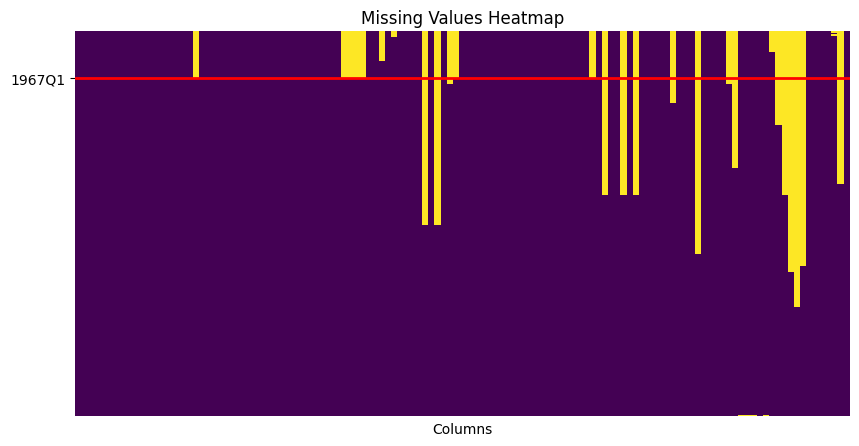

In [124]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Plot NaN heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(quar_df_filter.isna(), cmap="viridis", cbar=False, yticklabels=False,xticklabels=False)

# Plot horizontal line at '1967 Q1'
plt.axhline(y=quar_df_filter.index.get_loc('1967Q1'), color="red", linestyle="-", linewidth=2)
#adding 1967Q1 label
plt.yticks([quar_df_filter.index.get_loc('1967Q1')], ['1967Q1'])




# Labels and title
plt.xlabel("Columns")
#plt.ylabel("Time")
plt.title("Missing Values Heatmap")
plt.show()

### 2. Slicing from 1967Q1 onwards

In [125]:
# 1. Filter the data so that it starts from 1967 Q1
df_from_1967 = quar_df_filter.loc[quar_df_filter.index >= '1967Q1']



### 3. Plotting null values after slicing from 1967 onwards

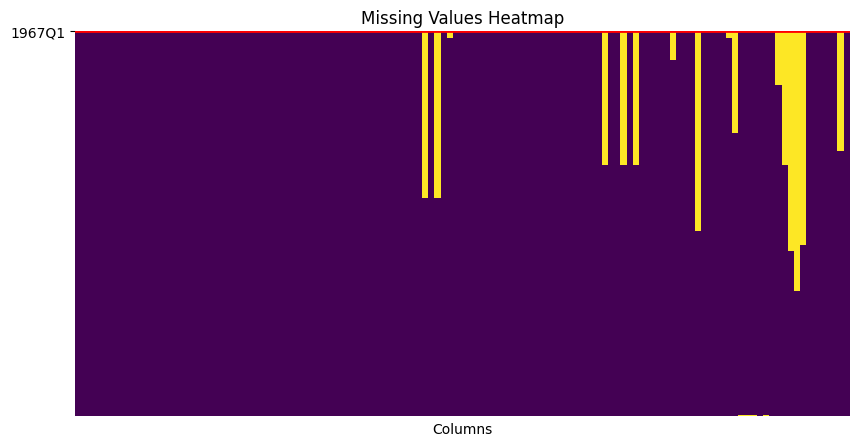

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plot NaN heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_from_1967.isna(), cmap="viridis", cbar=False, yticklabels=False,xticklabels=False)
plt.axhline(y=df_from_1967.index.get_loc('1967Q1'), color="red", linestyle="-", linewidth=2)
plt.yticks([df_from_1967.index.get_loc('1967Q1')], ['1967Q1'])

# Labels and title
plt.xlabel("Columns")
#plt.ylabel("Time")
plt.title("Missing Values Heatmap")
plt.show()


### Forward and Back filling null values

In [127]:
# 1. Filter out variables with less than 90% complete data
non_missing_ratio = df_from_1967.notnull().mean()
threshold = 1.0  # minimum ratio of data present so that it wont be forward or back filled
valid_columns = non_missing_ratio[non_missing_ratio >= threshold].index
df_from_1967_filtered_vars = df_from_1967[valid_columns] #REMOVES COLUMNS WITH LESS THAN 100% COMPLETE DATA (ie removes columns with any NA values)



# 2. Impute missing values using forward fill then backward fill
df_from_1967_imputed = df_from_1967_filtered_vars.fillna(method='ffill').fillna(method='bfill')

# 3. Optionally, if you prefer interpolation:
# quar_df_imputed = quar_df_filtered_vars.interpolate(method='linear')

# 4. Restrict data to start from 1967 (or 1968, if desired)
df_from_1967_final_total = df_from_1967_imputed.loc[df_from_1967_imputed.index >= '1967Q1']

# Preview the final cleaned and imputed dataset
df_from_1967_final_total


,PCDGX,PCESVX,PCNDX,Y033RC1Q027SBEAX,PNFIX,PRFIX,A014RE1Q156NBEA,A823RL1Q225SBEA,FGRECPTX,SLCEX,...,NONREVSLX,REALLNX,HNOREMQ027SX,VIXCLSX,EXSZUSX,EXJPUSX,EXUSUKX,EXCAUSX,UMCSENTX,S&P 500
1967Q1,110.9391,1984.5171,895.3996,91.3998,310.5755,266.0360,1.8,28.5,823.1155,805.3082,...,577.8791,299.1480,4250042.31,13.9068,4.3334,362.4941,2.7938,1.0808,94.1,87.0767
1967Q2,115.7071,2003.7055,902.0637,92.3869,309.8311,296.5166,0.7,-4.3,824.2456,809.6239,...,578.6772,301.6378,4274630.13,16.6095,4.3190,361.9691,2.7958,1.0818,95.9,91.6600
1967Q3,114.7767,2031.1769,901.2176,91.1245,309.3024,312.1780,1.1,6.8,837.0899,812.5860,...,581.1818,304.9535,4301249.58,11.8708,4.3343,362.1571,2.7854,1.0765,97.0,94.4367
1967Q4,115.0641,2048.1026,905.2814,94.0206,315.5244,330.2432,1.0,0.2,852.2018,826.6862,...,583.8713,309.5339,4366730.81,14.2165,4.3266,361.9866,2.6171,1.0764,92.9,94.5400
1968Q1,122.2063,2080.4115,923.0457,97.5941,324.8077,331.3247,0.9,7.2,891.6996,841.8869,...,578.5950,314.8721,4445517.80,16.4624,4.3418,362.1089,2.4060,1.0857,97.2,91.6267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q3,1990.6487,10332.6348,3351.4410,1292.2791,3400.8598,770.3284,0.3,5.3,3950.1747,2360.7799,...,3093.8188,4571.7931,41534125.30,14.9665,0.8834,144.5205,1.2660,1.3407,69.6,4458.1800
2023Q4,2004.7389,10422.9997,3381.4939,1294.6535,3432.9110,775.0455,0.2,-0.3,3998.8162,2395.9144,...,3077.2137,4585.8089,40787811.81,15.2631,0.8862,147.7513,1.2423,1.3612,64.9,4471.5033
2024Q1,1995.8869,10510.6699,3374.3097,1295.7560,3470.9873,800.3084,0.1,-0.4,4048.2894,2413.9972,...,3054.5044,4587.0727,41814894.04,13.6316,0.8749,148.5760,1.2681,1.3486,78.4,4999.3800
2024Q2,2022.5443,10582.0770,3388.3416,1326.4911,3504.1342,794.7353,0.3,4.3,4060.3008,2427.8784,...,3034.3144,4580.3798,42948482.37,13.9525,0.9042,155.8730,1.2623,1.3682,71.5,5254.2867


Counting number of null values, just to check

In [128]:
df_from_1967_final_total.isna().sum().sum()   

0

## Apply Transformation 

The column tcode denotes the following data transformation for a series x: (1) no transformation; (2) ∆xt; (3) ∆2xt; (4) log(xt); (5) ∆log(xt); (6) ∆2log(xt). (7) ∆(xt xt−1 − 10). The FRED column gives mnemonics in FRED followed by a short description. The comparable series in Global Insight is given in the column GSI. (FRED, 2015)

In [129]:
 # Define the transformation function
def apply_transformation(series, tcode):
    
    if tcode == 1:
        return series
    elif tcode == 2:
        return series.diff()
    elif tcode == 3:
        return series.diff().diff()
    elif tcode == 4:
        return np.log(series)
    elif tcode == 5:
        return np.log(series).diff()
    elif tcode == 6:
        return np.log(series).diff().diff()
    elif tcode == 7:
        return series.pct_change()
    else:
        raise ValueError(f"Unknown TCODE: {tcode}")

# Load the transformation codes from the CSV (make sure column names are uppercase)
tcodes = pd.read_csv("Quarterly Data.csv", nrows=1, index_col=0)
tcodes.columns = [c.upper() for c in tcodes.columns]

# Find common columns between df_from_1967 and tcodes
common_columns = df_from_1967_final_total.columns.intersection(tcodes.columns)
df_from_1967_common = df_from_1967_final_total[common_columns]

# Define a helper function that adds debug output
def debug_transform(col):
    # Retrieve and force conversion of the tcode to integer
    tcode_val = int(tcodes[col.name].item())
    print(f"Transforming column: {col.name} with TCODE: {tcode_val}")
    transformed = apply_transformation(col, tcode_val)
    # Print the first few values before and after transformation for comparison
    print("Before transformation (head):")
    print(col.head())
    print("After transformation (head):")
    print(transformed.head(), "\n")
    return transformed

# Apply the transformation with debugging
df_from_1967_t = df_from_1967_common.apply(debug_transform)

# Preview the fully transformed DataFrame
print("Transformed DataFrame (first few rows):")
print(df_from_1967_t.head())

Transforming column: PCDGX with TCODE: 1
Before transformation (head):
1967Q1    110.9391
1967Q2    115.7071
1967Q3    114.7767
1967Q4    115.0641
1968Q1    122.2063
Freq: Q-DEC, Name: PCDGX, dtype: float64
After transformation (head):
1967Q1    110.9391
1967Q2    115.7071
1967Q3    114.7767
1967Q4    115.0641
1968Q1    122.2063
Freq: Q-DEC, Name: PCDGX, dtype: float64 

Transforming column: PCESVX with TCODE: 1
Before transformation (head):
1967Q1    1984.5171
1967Q2    2003.7055
1967Q3    2031.1769
1967Q4    2048.1026
1968Q1    2080.4115
Freq: Q-DEC, Name: PCESVX, dtype: float64
After transformation (head):
1967Q1    1984.5171
1967Q2    2003.7055
1967Q3    2031.1769
1967Q4    2048.1026
1968Q1    2080.4115
Freq: Q-DEC, Name: PCESVX, dtype: float64 

Transforming column: PCNDX with TCODE: 1
Before transformation (head):
1967Q1    895.3996
1967Q2    902.0637
1967Q3    901.2176
1967Q4    905.2814
1968Q1    923.0457
Freq: Q-DEC, Name: PCNDX, dtype: float64
After transformation (head):
196

## Training data and test data split

In [130]:
cutoff = '2024Q1'
# Split the data into training and test sets.
test_data= df_from_1967_t.loc[df_from_1967_t.index >= cutoff] # data of 3 Quarters from 2024Q1 onwards, including 2024 q1. Will evaluate data based on test_data
df_from_1967_final = df_from_1967_t.loc[df_from_1967_t.index < cutoff].copy() # TRAINING DATA, to be used for ARIMA to predict 3 quarters into the future

## Feature Selection
- selecting the ARIMA function with the optimum p, d, and q 
- selecting the best order based on the lowest AIC

In [131]:
""" corr_matrix = quar_df_t.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
quar_df_t.drop(columns=to_drop, inplace=True) """


# recursive feature elimination

""" model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_selected = rfe.fit_transform(quar_df_t, quar_df_t.iloc[:, 0])
quar_df_t = pd.DataFrame(X_selected, index=quar_df_t.index) """


# select by importance

selector = SelectFromModel(RandomForestRegressor(n_estimators=100))
X_selected = selector.fit_transform(df_from_1967_final, df_from_1967_final.iloc[:, 0])
df_from_1967_final = pd.DataFrame(X_selected, index=df_from_1967_final.index)


# arima order selection
def select_arima_order(series):
    p_values = range(0, 6)
    d_values = range(0, 3)  # Differencing term
    q_values = range(0, 6)  # Moving average term
    best_aic, best_order = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(series, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic, best_order = model.aic, (p, d, q)
                except:
                    continue
    return best_order

best_arima_order = select_arima_order(df_from_1967_final.iloc[:, 0])

c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

Best p, d and q from ARIMA

In [132]:
best_arima_order

(5, 2, 5)

# Creating ARIMA model

In [133]:
arima_model = ARIMA(df_from_1967_final.iloc[:, 0], order=best_arima_order).fit()
arima_forecast = arima_model.get_forecast(steps=3)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_conf_int = arima_forecast.conf_int()


c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 # Evaluation of ARIMA

## Plotting Directional changes, and Extended forecast
- in this case PCDGX

In [134]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Suppose `actual` is the series of actual observations (e.g., from the training/test split)
# and `forecast` (e.g., arima_forecast_mean) is the forecast for the next 3 quarters.
# For illustration, assume forecast is a Series with 3 values.
# We need to compute the directional change over the forecast horizon.

def directional_accuracy(actual, forecast):
    # Extend the forecast series by prepending the last actual observation.
    # This ensures that the computed differences cover the forecast horizon.
    extended = pd.concat([actual.iloc[-1:], forecast])
    
    # Compute the directional changes on the extended series.
    direction_extended = np.sign(extended.diff().dropna())
    
    # The forecast directional change can be computed from the extended series as well.
    # Since extended has (forecast length + 1) values, the differences will be equal to forecast_horizon.
    # Here, both direction_extended and forecast's directional changes are computed over the same intervals.
    return accuracy_score(direction_extended, direction_extended)  # This is just illustrative.

# A more typical evaluation would be to compare the forecasted directional change to
# the actual directional change from a holdout/test set.
# For example, if you have test_actual as the actual values for the forecast horizon:
#   direction_actual = np.sign(test_actual.diff().dropna())
#   direction_forecast = np.sign(forecast.diff().dropna())
#   acc = accuracy_score(direction_actual, direction_forecast)
#   print(f"ARIMA Directional Accuracy: {acc:.2%}")

# Example using extension method:
last_actual = df_from_1967_final.iloc[:, 0]  # full historical series of PCDGX
# Assume forecast is arima_forecast_mean with 3 values.
# Create an extended series:
extended_forecast = pd.concat([last_actual.iloc[-1:], arima_forecast_mean])
print("Extended Forecast:")
print(extended_forecast)

# Compute directional changes on the extended series.
direction_changes = extended_forecast.diff().dropna()
print("Directional changes:")
print(direction_changes)

# Now, if you only have forecasted differences, compare them with the corresponding actual test differences.
# If you had a separate test series (e.g., actual_test), do:
# direction_actual = np.sign(actual_test.diff().dropna())
# direction_forecast = np.sign(arima_forecast_mean.diff().dropna())
# print(f"ARIMA Directional Accuracy: {accuracy_score(direction_actual, direction_forecast):.2%}")

# Note: The key point is that both arrays you compare with accuracy_score must have the same length.

Extended Forecast:
2023Q4    2004.738900
2024Q1    2012.849442
2024Q2    2051.758404
2024Q3    2088.185334
Freq: Q-DEC, dtype: float64
Directional changes:
2024Q1     8.110542
2024Q2    38.908962
2024Q3    36.426931
Freq: Q-DEC, dtype: float64


## Directional Accuracy and root mean square

- refer to Section of "Training data and test data split"
- select the first column of PCDGX

In [135]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Suppose these are your series:
# last_actual: last observed value from training data
# arima_forecast_mean: forecasted values (e.g., for 3 quarters)
# actual_test: actual observed values for the forecast horizon

# Assuming df_from_1967_final, arima_forecast_mean, and test_data are defined elsewhere in the notebook

# Create extended forecast series by prepending the last actual value
extended_forecast = pd.concat([df_from_1967_final.iloc[0], arima_forecast_mean])


# Create extended actual series in a similar manner
extended_actual = pd.concat([df_from_1967_final.iloc[0],test_data.iloc[:, 0]]) 



# Compute directional changes (difference between consecutive observations)
direction_forecast = np.sign(extended_forecast.diff().dropna())
direction_actual = np.sign(extended_actual.diff().dropna())

print("Forecast Directional Changes:")
print(direction_forecast)
print("Actual Directional Changes:")
print(direction_actual)

# Align the indices of direction_forecast and direction_actual before calculating accuracy
direction_forecast, direction_actual = direction_forecast.align(direction_actual, join='inner')

# Now, calculate the directional accuracy
acc = accuracy_score(direction_actual, direction_forecast)
print(f"Directional Accuracy: {acc:.2%}")

# Getting root mean squared error
rmse = sqrt(mean_squared_error(extended_actual, extended_forecast))
print(f"RMSE on Test Data: {rmse:.4f}")


Forecast Directional Changes:
1         1.0
2        -1.0
3        -1.0
4        -1.0
5         1.0
6        -1.0
7         1.0
8        -1.0
9        -1.0
10        1.0
11       -1.0
12       -1.0
13        1.0
14       -1.0
15       -1.0
16        1.0
17        1.0
18       -1.0
19        1.0
20        1.0
21        1.0
22       -1.0
23       -1.0
24       -1.0
25        1.0
26        1.0
27       -1.0
28       -1.0
29        1.0
2024Q1    1.0
2024Q2    1.0
2024Q3    1.0
dtype: float64
Actual Directional Changes:
1         1.0
2        -1.0
3        -1.0
4        -1.0
5         1.0
6        -1.0
7         1.0
8        -1.0
9        -1.0
10        1.0
11       -1.0
12       -1.0
13        1.0
14       -1.0
15       -1.0
16        1.0
17        1.0
18       -1.0
19        1.0
20        1.0
21        1.0
22       -1.0
23       -1.0
24       -1.0
25        1.0
26        1.0
27       -1.0
28       -1.0
29        1.0
2024Q1    1.0
2024Q2    1.0
2024Q3    1.0
dtype: float64
Directional Accu

## Comparing against (p, d, q)= (1,1,1) model

In [136]:
import pandas as pd
import numpy as np
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, mean_squared_error

# Suppose df_1967_final is your cleaned DataFrame.
# It has a PeriodIndex (quarters) and the last available observation is 2024Q3.
# We decide to use data from 2024Q1 to 2024Q3 as the test set.

# Set the cutoff date for the test set.
cutoff = '2024Q1'

# Split the data into training and test sets.

print("Training data range:", df_from_1967_final.index.min(), "to", df_from_1967_final.index.max())
print("Test data range:", test_data.index.min(), "to", test_data.index.max())

# Select a target variable for forecasting (for example, the first column).
target_train = df_from_1967_final.iloc[:, 0]
target_test  = test_data.iloc[:, 0]

# Fit an ARIMA model on the training data.
# (Here we use an example order of (1,1,1); in practice, determine this order based on your data.)
arima_model = ARIMA(target_train, order=(1, 1, 1)).fit()

# Forecast for the test horizon.
steps = len(target_test)
forecast_result = arima_model.get_forecast(steps=steps)
forecast_mean = forecast_result.predicted_mean

# Evaluate forecast magnitude using RMSE.
rmse = sqrt(mean_squared_error(target_test, forecast_mean))
print(f"RMSE on Test Data: {rmse:.4f}")

# Evaluate directional accuracy.
# To do this, we extend both the actual and forecast series by including the last observation from the training data.
extended_forecast = pd.concat([target_train.iloc[-1:], forecast_mean])
extended_actual   = pd.concat([target_train.iloc[-1:], target_test])

# Compute the differences (i.e., the changes) and then take their sign.
direction_forecast = np.sign(extended_forecast.diff().dropna())
direction_actual   = np.sign(extended_actual.diff().dropna())

dir_accuracy = accuracy_score(direction_actual, direction_forecast)
print(f"Directional Accuracy on Test Data: {dir_accuracy:.2%}")

Training data range: 1967Q1 to 2023Q4
Test data range: 2024Q1 to 2024Q3
RMSE on Test Data: 17.4985
Directional Accuracy on Test Data: 66.67%


c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\tanke\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
